In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import exponnorm
from scipy.optimize import curve_fit, minimize
import scipy
from scipy.interpolate import interp1d
import scipy.optimize as optimize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from functions import *

SyntaxError: invalid syntax (<ipython-input-2-d956eb6ca02e>, line 11)

In [2]:
data = pd.read_excel("TACs.xlsx", sheet_name=None)
relevant_keys = ['PT 300 ml Qclear 2', 'PT 300 ml Qclear 1', 'PT 200 ml Qclear 2', 'PT 200 ml Qclear 1', 'PT 100 ml Qclear 2', 'PT 100 ml Qclear 1']
qclear = [2, 1, 2, 1, 2, 1]
sizes = [300, 300, 200, 200, 100, 100]

In [3]:
frames = []
for key, clear, size in zip(relevant_keys, qclear, sizes):
    frame = data[key]
    df = frame.loc[5:]
    df.columns = ["time", "input", "tissue"]
    df[['time_start', 'time_end']] = df['time'].str.split(' - ', 1, expand=True)
    df["sample"] = clear
    df["flow"] = size
    df = df.astype({'input': 'float64', 'tissue': 'float64', 'time_start': 'int32', 'time_end': 'int32'})
    df = df.drop(["time"], axis=1)
    df["midpoint"] = (df["time_end"] + df["time_start"]) / 2
    frames.append(df)
df = pd.concat(frames)

/home/mikael/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/mikael/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [4]:
maxes = []
sizes = []
samples = []
input_integrals = []
tissue_integrals = []
colors = ["k", "b", "r", "c", "g", "m"]
names = []
input_maxes = []
input_x_maxes = []
tissue_x_maxes = []
stds = []
skewnesses = []
means = []
for name, group in df.groupby(['sample', 'flow']):
    sizes.append(group["flow"].iloc[0])
    q = group["sample"].iloc[1]
    if q == 1:
        samples.append(1)
    else:
        samples.append(2)
    cubic_tissue = interp1d(group["midpoint"], group["tissue"], kind='cubic')
    cubic_input = interp1d(group["midpoint"], group["input"], kind='cubic')

    min_inter, max_inter = min(group["midpoint"]), max(group["midpoint"])
    xnew = np.linspace(min_inter, max_inter, num=400, endpoint=True)
    #plt.title("Cubic splines")
    #plt.plot(group["midpoint"], group["input"], 'o', xnew, cubic_input(xnew), '-')
    
    
    
    integral = np.trapz(group["input"], x=group["midpoint"])
    input_integrals.append(integral)
    
    integral = np.trapz(group["tissue"], x=group["midpoint"])
    tissue_integrals.append(integral)
    
    names.append(name)
    bounds = [(min_inter+1, max_inter-1)]
    
    results = optimize.minimize(lambda x: -cubic_input(x), x0=(100), bounds = bounds)
    input_x_maxes.append(results["x"][0])
    input_maxes.append(-results["fun"][0])
    
    results = optimize.minimize(lambda x: -cubic_tissue(x), x0=(100), bounds = bounds)
    tissue_x_maxes.append(results["x"][0])
    maxes.append(-results["fun"][0])

    indx = np.argmax(group["input"] > np.max(group["input"]) * 0.20)
    
    standard_dev = np.std(group["tissue"])
    skewness = scipy.stats.skew(group["tissue"])
    
    stds.append(standard_dev)
    skewnesses.append(skewness)
    means.append(np.mean(group["tissue"]))
    
    
    #plt.savefig("cubic_splines.jpg")

feature_df = pd.DataFrame({
    "flow": sizes,
    "tissue_max": maxes,
    "tissue_x_max": tissue_x_maxes,
    "sample": samples,
    "input_integral": input_integrals,
    "tissue_integral": tissue_integrals,
    "input_max": input_maxes,
    "input_x_max": input_x_maxes,
    "std": stds,
    "skewness": skewnesses,
    "mean": means
})
feature_df["peak_time_difference"] = feature_df["tissue_x_max"] - feature_df["input_x_max"]
df = pd.merge(df, feature_df, how="left", on=["flow", "sample"])
df

/home/mikael/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return bound(*args, **kwds)


,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,1.456478e+03,407.96191,0,5,2,300,2.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
1,1.278932e+03,459.05683,5,10,2,300,7.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
2,2.265328e+04,646.44457,10,15,2,300,12.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
3,4.574733e+05,10505.08901,15,20,2,300,17.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
4,1.643083e+06,89934.22971,20,25,2,300,22.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,1.392625e+06,784895.39999,140,160,1,100,150.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
140,6.902623e+05,925024.12368,160,190,1,100,175.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
141,2.563172e+05,870937.93689,190,220,1,100,205.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
142,7.789175e+04,634442.87209,220,250,1,100,235.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009


In [5]:
df["scaled_tissue"] = df["tissue"] / df["tissue_integral"]

In [6]:
x_s, sampled_scaled_tissue, sampled_tissue = [], [], []
samples, flows = [], []
num_samples = 10000
for name, group in df.groupby(['sample', 'flow']):
    results = get_interpolated_sample(min(df["midpoint"]), max(df["midpoint"]), group, num_samples, ["scaled_tissue", "tissue"], "midpoint")
    x_s.append(results[0])
    sampled_scaled_tissue.append(results[1][0])
    sampled_tissue.append(results[1][1])
    samples.append(group["sample"].iloc[0])
    flows.append(group["flow"].iloc[0])

sampled_dict = {
    "ss_tissue": [item for sublist in sampled_scaled_tissue for item in sublist],
    "s_tissue": [item for sublist in sampled_tissue for item in sublist],
    "x": [item for sublist in x_s for item in sublist],
    "flow": np.repeat(flows, num_samples),
    "sample": np.repeat(samples, num_samples)
}
sampled_df = pd.DataFrame(sampled_dict)
sampled_df

,ss_tissue,s_tissue,x,flow,sample
0,0.000012,1267.153700,2.500000,100,1
1,0.000012,1267.412249,2.526253,100,1
2,0.000012,1267.670307,2.552505,100,1
3,0.000012,1267.927877,2.578758,100,1
4,0.000012,1268.184960,2.605011,100,1
...,...,...,...,...,...
59995,0.000034,1349.388320,264.894989,300,2
59996,0.000034,1349.232885,264.921242,300,2
59997,0.000034,1349.077191,264.947495,300,2
59998,0.000034,1348.921236,264.973747,300,2


In [7]:
sampled_df = pd.merge(sampled_df, feature_df, how="inner", on=["sample", "flow"])
sampled_df

,ss_tissue,s_tissue,x,flow,sample,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,0.000012,1267.153700,2.500000,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,0.000012,1267.412249,2.526253,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
2,0.000012,1267.670307,2.552505,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
3,0.000012,1267.927877,2.578758,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
4,0.000012,1268.184960,2.605011,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.000034,1349.388320,264.894989,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59996,0.000034,1349.232885,264.921242,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59997,0.000034,1349.077191,264.947495,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59998,0.000034,1348.921236,264.973747,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


In [14]:
restricted_df = []
for i, group in sampled_df.groupby(["flow", "sample"]):
    print(max(group["s_tissue"]) * 0.15)
    sub_df = group[group["s_tissue"] > max(group["s_tissue"]) * 0.05]
    #plt.scatter(group["midpoint"], group["tissue"])
    #plt.scatter(sub_df["midpoint"] + 2, sub_df["tissue"])
    #plt.show()
    restricted_df.append(sub_df)
    print(len(sub_df))
    


139899.0010118033
6482
102356.92386735584
8731
124996.25677284705
5262
129355.17841236477
5217
117970.72652720641
3738
120064.32080873186
3758


STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [1.44557253e+00 2.07844955e+01 7.16095098e-03 3.16850737e-02]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [3459232.0009053]


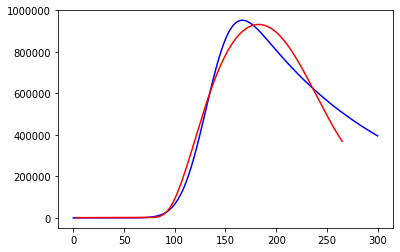

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [1.99250213e+00 2.05985847e+01 1.10789411e-02 2.21582257e-02]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1967881.58978735]


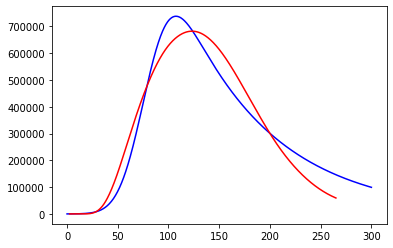

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [ 3.09316198 18.16339275  0.03262403  0.02249684]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1354484.88791345]


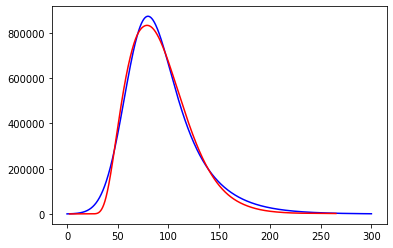

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [3.57009865e+00 2.14643324e+01 4.10642618e-02 1.88958103e-02]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1169426.41655795]


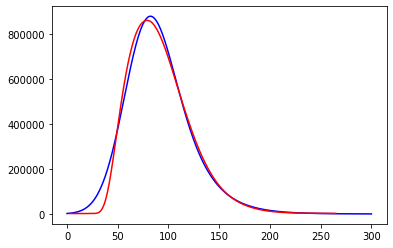

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [ 2.44039242 11.19489653  0.04237496  0.03647247]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1419294.46692507]


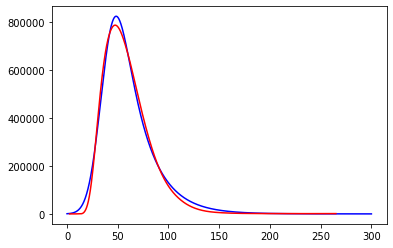

STARTING FIRST OPTIMIZE
ENDING FIRST OPTIMIZE. PARAMS: [ 2.43753335 11.26758929  0.04192676  0.03622708]
STARTING SECOND OPTIMIZE
ENDING SECOND OPTIMIZE. PARAMS: [1449293.18105985]


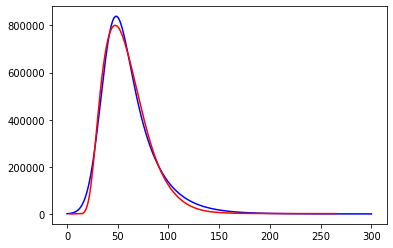

,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,100,1,133.249437,1.445573,0.007161,20.784495,3.459232e+06,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,100,2,78.511753,1.992502,0.011079,20.598585,1.967882e+06,682379.493759,123.186942,1.219042e+08,8.881070e+07,1.772555e+06,58.586732,237359.182831,0.571097,242688.100938,64.600210
2,200,1,62.781911,3.093162,0.032624,18.163393,1.354485e+06,833308.431967,78.880157,8.032373e+07,6.020789e+07,2.323809e+06,47.316101,310345.925135,0.689358,268301.277536,31.564057
3,200,2,66.065430,3.570099,0.041064,21.464332,1.169426e+06,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192
4,300,1,36.718591,2.440392,0.042375,11.194897,1.419294e+06,786471.515392,47.416007,5.215457e+07,3.891364e+07,2.355921e+06,28.583950,299429.502224,0.552632,275034.624421,18.832057
5,300,2,36.609103,2.437533,0.041927,11.267589,1.449293e+06,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


In [17]:
groups = sampled_df.groupby(["flow", "sample"]) # NON PARAMETRIC

results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": [],
    "h": []
}

for i, group in groups:
    mu_x_alkuarvaus = 6.3259260
    sigma_alkuarvaus = 20
    lambda_alkuarvaus = 0.05

    bounds = [(None, None), (1e-5, None), (1e-5, None), (None, None)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]
    print("STARTING FIRST OPTIMIZE")
    # SOVITTAA NORMALISOITUUN KÄYRÄÄN PARAMETRIT
    res1 = scipy.optimize.minimize(EMG_loss, args=group, x0=x_0, bounds=bounds)
    print(f"ENDING FIRST OPTIMIZE. PARAMS: {res1['x']}")
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + res1["x"][0] * 1000 / group["flow"]).iloc[0]
    sigma = res1["x"][1]
    lambda_ = res1["x"][2]

    emg_params = {
        "mu_x": res1["x"][0],
        "sigma": sigma,
        "lambda_": lambda_
    }

    print("STARTING SECOND OPTIMIZE")
    # SOVITTAA KORKEUSPARAMETRIN NIIN ETTÄ SE NORMALISOIMATON MÄTSÄÄ OIKEAAN
    res2 = scipy.optimize.minimize(EMG_loss_h, args=(group, emg_params), x0=[80000])
    print(f"ENDING SECOND OPTIMIZE. PARAMS: {res2['x']}")

    h = res2["x"][0]


    pred_y = EMG(x_range, mu, sigma, lambda_, h)
    plt.plot(x_range, pred_y, color="b")
    plt.plot(group["x"], group["s_tissue"], color="r")
    #print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {res["x"][1]}, LAMBDA: {res["x"][2]}, MU_x: {res["x"][0]}')
    plt.show()
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res1["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    results_dict["h"].append(h)

results_df = pd.DataFrame(results_dict)
results_df = results_df.merge(feature_df, how="inner", on=["flow", "sample"])
results_df

0    3.459232e+06
1    1.967882e+06
2    1.354485e+06
3    1.169426e+06
4    1.419294e+06
5    1.449293e+06
Name: h, dtype: float64

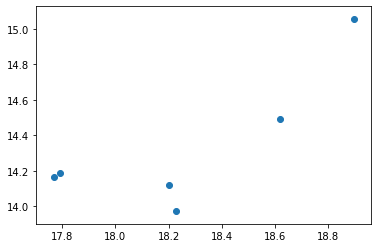

In [ ]:
plt.scatter(np.log(results_df["input_integral"]), np.log(results_df["h"]))
results_df["h"]

138753.618552


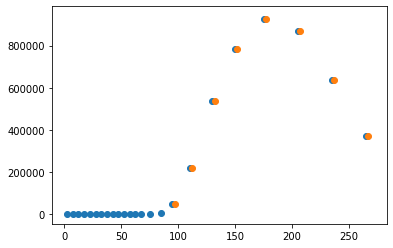

101659.0344705


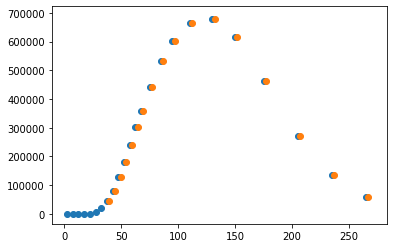

124048.80665249999


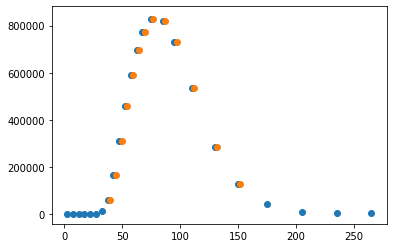

128306.6649795


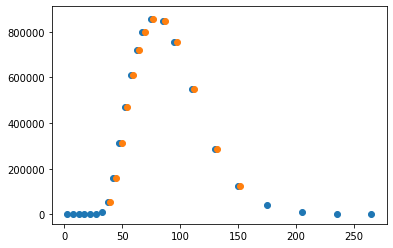

117969.617829


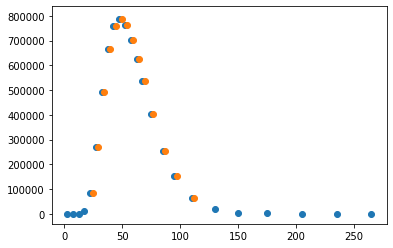

120064.225374


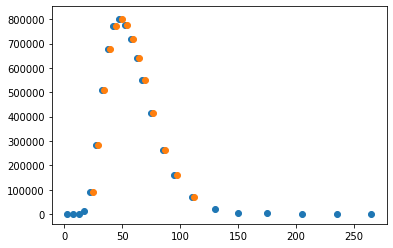

,input,tissue,time_start,time_end,sample,flow,midpoint,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference,scaled_tissue
136,1.226913e+06,47679.39535,90,100,1,100,95.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.000437
137,2.166310e+06,220800.09620,100,120,1,100,110.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.002023
138,2.133430e+06,535566.06663,120,140,1,100,130.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.004906
139,1.392625e+06,784895.39999,140,160,1,100,150.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.007190
140,6.902623e+05,925024.12368,160,190,1,100,175.0,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,0.008473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13,8.261001e+04,548993.92377,65,70,2,300,67.5,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.013723
14,3.428285e+04,415955.78527,70,80,2,300,75.0,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.010397
15,6.977666e+03,264105.63827,80,90,2,300,85.0,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.006602
16,1.615249e+03,158971.67303,90,100,2,300,95.0,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,0.003974


In [ ]:
restricted_df = []
for i, group in df.groupby(["flow", "sample"]):
    print(max(group["tissue"]) * 0.15)
    sub_df = group[group["tissue"] > max(group["tissue"]) * 0.05]
    plt.scatter(group["midpoint"], group["tissue"])
    plt.scatter(sub_df["midpoint"] + 2, sub_df["tissue"])
    plt.show()
    restricted_df.append(sub_df)

restricted_df = pd.concat(restricted_df)
restricted_df


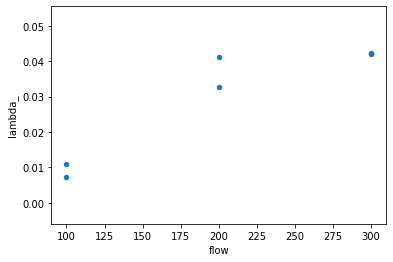

In [ ]:
results_df.plot.scatter("flow", "lambda_")

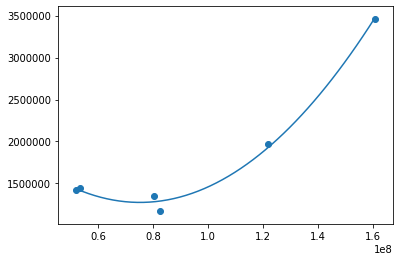

In [ ]:
def fit_polynomial(x_var, y_var):
        def fit_2d_poly(x, y, pred_val):
                coefficients = np.polyfit(x, y, 2)
                func = np.poly1d(coefficients)
                value = func(pred_val)
                return value
        x_range = np.linspace(min(results_df[x_var]), max(results_df[x_var]))
        y_vals = fit_2d_poly(results_df[x_var], results_df[y_var], x_range)
        plt.plot(x_range, y_vals)
        plt.scatter(results_df[x_var], results_df[y_var])
fit_polynomial("input_integral", "h")

In [ ]:
selected = get_selected_df(results_df, 300, 2)
print(selected)

   flow  sample         mu      mu_x   lambda_      sigma             h  \
5   300       2  36.609103  2.437533  0.041927  11.267589  1.449293e+06   

      tissue_max  tissue_x_max  input_integral  tissue_integral     input_max  \
5  800428.816009     47.474071    5.337498e+07     4.000549e+07  2.401110e+06   

   input_x_max            std  skewness           mean  peak_time_difference  
5    28.483992  305452.965103  0.540881  282056.386815             18.990079  


In [ ]:
def get_model_params(flow, input_integral, results_df):
    mu_x = results_df[results_df["flow"]==flow]["mu_x"].mean()
    
    def fit_2d_poly(x, y, variable_to_predict):
        coefficients = np.polyfit(x, y, 2)
        func = np.poly1d(coefficients)
        value = func(variable_to_predict)
        return value
    
    sigma = fit_2d_poly(results_df["flow"], results_df["sigma"], flow)
    lambda_ = fit_2d_poly(results_df["flow"], results_df["lambda_"], flow)
    h = fit_2d_poly(results_df["input_integral"], results_df["h"], input_integral)
    return mu_x, sigma, lambda_, h

get_model_params(selected["flow"].iloc[0], selected["input_integral"].iloc[0], results_df)

(2.4389628846735034,
 11.231242908323306,
 0.042150857517905024,
 1417588.178784034)

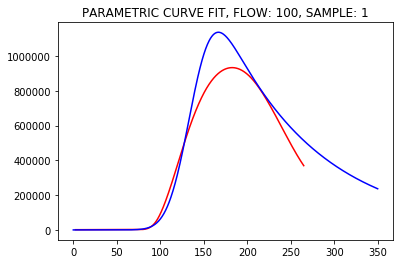

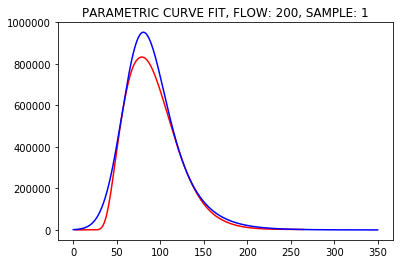

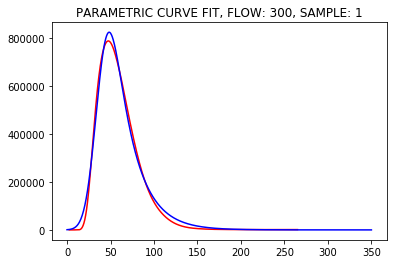

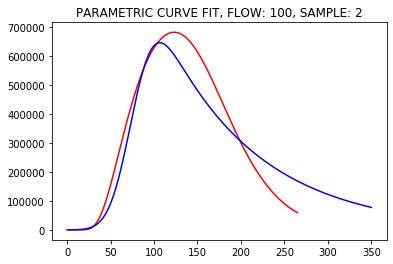

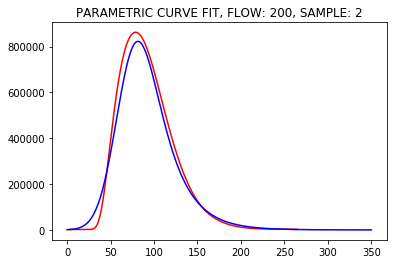

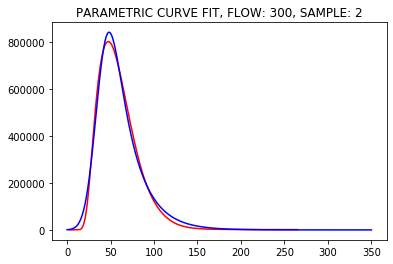

In [ ]:
for i, group in results_df.groupby(["sample", "flow"]):
    flow = group["flow"].iloc[0]
    sample = group["sample"].iloc[0]
    plot_against_predictions(flow, sample, results_df, sampled_df, save=True)

In [ ]:
sampled_df

,ss_tissue,s_tissue,x,flow,sample,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,0.000012,1267.153700,2.500000,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,0.000012,1267.412249,2.526253,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
2,0.000012,1267.670307,2.552505,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
3,0.000012,1267.927877,2.578758,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
4,0.000012,1268.184960,2.605011,100,1,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0.000034,1349.388320,264.894989,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59996,0.000034,1349.232885,264.921242,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59997,0.000034,1349.077191,264.947495,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079
59998,0.000034,1348.921236,264.973747,300,2,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


In [ ]:
results_df["input_integral"]

0    1.608301e+08
1    1.219042e+08
2    8.032373e+07
3    8.260553e+07
4    5.215457e+07
5    5.337498e+07
Name: input_integral, dtype: float64

In [ ]:
results_df

,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference
0,100,1,133.249437,1.445573,0.007161,20.784495,3.459232e+06,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009
1,100,2,78.511753,1.992502,0.011079,20.598585,1.967882e+06,682379.493759,123.186942,1.219042e+08,8.881070e+07,1.772555e+06,58.586732,237359.182831,0.571097,242688.100938,64.600210
2,200,1,62.781911,3.093162,0.032624,18.163393,1.354485e+06,833308.431967,78.880157,8.032373e+07,6.020789e+07,2.323809e+06,47.316101,310345.925135,0.689358,268301.277536,31.564057
3,200,2,66.065430,3.570099,0.041064,21.464332,1.169426e+06,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192
4,300,1,36.718591,2.440392,0.042375,11.194897,1.419294e+06,786471.515392,47.416007,5.215457e+07,3.891364e+07,2.355921e+06,28.583950,299429.502224,0.552632,275034.624421,18.832057
5,300,2,36.609103,2.437533,0.041927,11.267589,1.449293e+06,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079


                            OLS Regression Results                            
Dep. Variable:                      h   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     64.61
Date:                Wed, 03 Nov 2021   Prob (F-statistic):            0.00342
Time:                        14:14:57   Log-Likelihood:                -78.554
No. Observations:                   6   AIC:                             163.1
Df Residuals:                       3   BIC:                             162.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -4.519e+06   9.27e+05     -4.

/home/mikael/anaconda3/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  "samples were given." % int(n), ValueWarning)


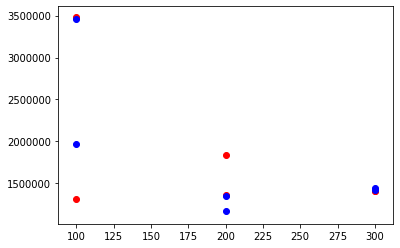

In [ ]:
fit = smf.ols('h ~ input_integral + flow', data=results_df).fit()
print(fit.summary())
y_pred = fit.predict(feature_df)
plt.scatter(results_df["flow"], y_pred, color="r")
plt.scatter(results_df["flow"], results_df["h"], color="b")

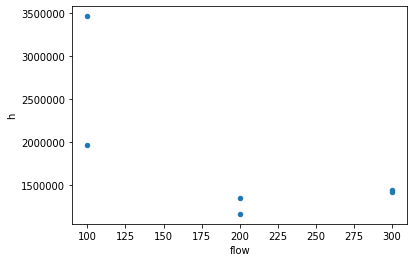

In [ ]:
results_df.plot.scatter("flow", "h")

In [ ]:

def plot_against_predictions(flow, sample, results_df, df):
    #CREATE X-RANGE, GET MODEL PARAMETERS
    x_range = np.linspace(0, 350, 700)
    mu_x, sigma, lambda_ = get_model_params(flow, results_df)
    data = get_selected_df(df, flow, sample)
    # TRANSFORM MU_X -> MU
    mu = (data["input_x_max"] + mu_x * 1000 / data["flow"]).iloc[0]
    #CREATE Y-VALUES
    h = get_selected_df(results_df, flow, sample)["h"].iloc[0]
    emg_vals = EMG(x_range, mu, sigma, lambda_, h)

    plt.plot(data["x"], data["s_tissue"], color="r")
    plt.plot(x_range, emg_vals, color="b")

In [ ]:
plot_against_predictions(300, 1, results_df, sampled_df)

TypeError: get_model_params() missing 1 required positional argument: 'results_df'

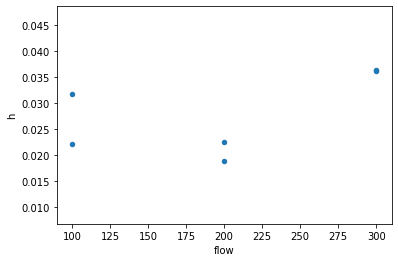

In [ ]:
results_df.plot.scatter("flow", "h")

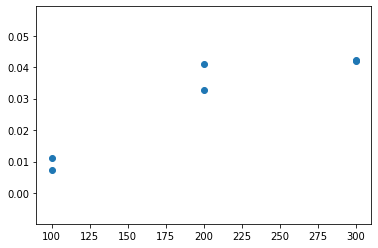

In [ ]:
plt.scatter(results_df["flow"], results_df["lambda_"])

In [ ]:
results_df

,flow,sample,mu,mu_x,lambda_,sigma,h,tissue_max,tissue_x_max,input_integral,tissue_integral,input_max,input_x_max,std,skewness,mean,peak_time_difference,predicted_values
0,100,1,133.249437,1.445573,0.007161,20.784495,0.031685,932660.007290,182.669720,1.608301e+08,1.091706e+08,2.305769e+06,118.793711,309106.389210,1.395397,184164.407288,63.876009,17.930943
1,100,2,78.511753,1.992502,0.011079,20.598585,0.022158,682379.493759,123.186942,1.219042e+08,8.881070e+07,1.772555e+06,58.586732,237359.182831,0.571097,242688.100938,64.600210,17.667981
2,200,1,62.781911,3.093162,0.032624,18.163393,0.022497,833308.431967,78.880157,8.032373e+07,6.020789e+07,2.323809e+06,47.316101,310345.925135,0.689358,268301.277536,31.564057,17.272113
3,200,2,66.065430,3.570099,0.041064,21.464332,0.018896,862367.856082,78.895128,8.260553e+07,6.188868e+07,2.476852e+06,48.214937,320526.422085,0.701743,276009.680701,30.680192,17.298694
4,300,1,36.718591,2.440392,0.042375,11.194897,0.036472,786471.515392,47.416007,5.215457e+07,3.891364e+07,2.355921e+06,28.583950,299429.502224,0.552632,275034.624421,18.832057,16.862313
5,300,2,36.609103,2.437533,0.041927,11.267589,0.036227,800428.816009,47.474071,5.337498e+07,4.000549e+07,2.401110e+06,28.483992,305452.965103,0.540881,282056.386815,18.990079,16.884262


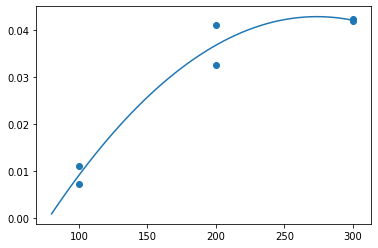

In [ ]:
coefficients = np.polyfit(results_df["flow"], results_df["lambda_"], 2)
func = np.poly1d(coefficients)
x_range = np.linspace(80, 300)
y_s = func(x_range)
plt.plot(x_range, y_s)
plt.scatter(results_df["flow"], results_df["lambda_"])

In [ ]:
aa = results_df.groupby(["flow"]).mean()
aa.reset_index(level=0, inplace=True)

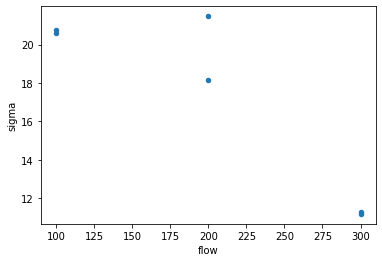

In [ ]:
results_df.plot.scatter("flow", "sigma")

FLOW: 100, SAMPLE: 1, SIGMA: 3218.569319725927, LAMBDA: 8.630069276865442e-07, MU_x: 6.283315221181237


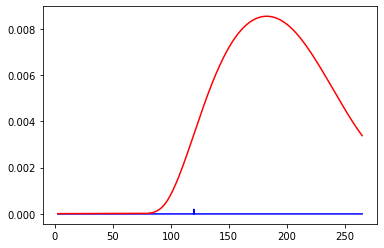

FLOW: 100, SAMPLE: 2, SIGMA: 3218.566713739128, LAMBDA: 8.437611749139164e-07, MU_x: 6.292302956573166


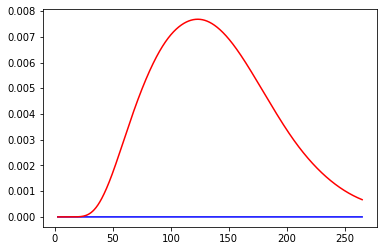

KeyboardInterrupt: 

In [ ]:
groups = sampled_df.groupby(["flow", "sample"]) #PARAMETRIC
results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": []
}
for i, group in groups:
    mu_x_alkuarvaus = 6.3259260
    sigma_alkuarvaus = 32.18558379022995 * group["flow"].iloc[0]
    lambda_alkuarvaus = 0.01275965604990928 / group["flow"].iloc[0]
    bounds = [(mu_x_alkuarvaus - 4, mu_x_alkuarvaus + 4),
         (4, 300),
         (0.01, 20), (0, 3)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]

    res = scipy.optimize.minimize(EMG_loss, args=group, x0=x_0)
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + params[0] * 1000 / group["flow"]).iloc[0]
    sigma = (params[1] / group["flow"]).iloc[0]
    lambda_ = (np.exp(params[2] * group["flow"])).iloc[0]
    h = params[3]
    pred_y = EMG(group["x"], mu, sigma, lambda_, h)
    plt.plot(group["x"], pred_y, color="b")
    plt.plot(group["x"], group["ss_tissue"], color="r")
    print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {res["x"][1]}, LAMBDA: {res["x"][2]}, MU_x: {res["x"][0]}')
    plt.show()
          
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    

In [ ]:
results_df = pd.DataFrame(results_dict)
results_df = results_df.merge(feature_df, how="inner", on=["flow", "sample"])
results_df

In [ ]:
fit = smf.ols('np.log(lambda_) ~ I(flow)', data=results_df).fit()
print(fit.summary())

In [ ]:
plt.scatter(results_df["flow"], np.log(results_df["lambda_"]), color="r")
x_range = np.linspace(1, 300, 400)

y_s = np.exp(fit.params[1] * x_range + fit.params[0])

plt.plot(x_range, np.log(y_s), color="b")

In [ ]:
results_df

In [ ]:
plt.scatter(results_df["flow"], results_df["sigma"])

In [ ]:
#fit = smf.ols('sigma ~ I(1 / flow) + lambda_ - 1', data=results_df).fit()
fit = smf.ols('sigma ~ I(1 / flow) - 1', data=results_df).fit()
print(fit.summary())

In [ ]:
plt.scatter(results_df["flow"], results_df["sigma"], color="r")
x_range = np.linspace(100, 300, 400)

y_s = fit.params[0] / x_range

plt.plot(x_range, y_s, color="b")

In [ ]:
#fit = smf.ols('sigma ~ I(1 / flow) + lambda_ - 1', data=results_df).fit()
fit = smf.ols('mu_x ~ flow - 1', data=results_df).fit()
print(fit.summary())

In [ ]:
plt.scatter(results_df["flow"], results_df["mu_x"], color="r")
x_range = np.linspace(1, 300, 400)

y_s = fit.params[0] * x_range

plt.plot(x_range, y_s, color="b")

In [ ]:
results_df

In [ ]:
#fit = smf.ols('sigma ~ I(1 / flow) + lambda_ - 1', data=results_df).fit()
fit = smf.ols('mu_x ~ flow - 1', data=results_df).fit()
print(fit.summary())

In [ ]:
def EMG_loss(params, data):
    """
    x[0] ja x[1]: lambda_ parametrit
    x[2]: sigma_parametri
    x[3]: mu_parametri
    x[4]: h
    """
    errors = []
    #print(params)
    groups = data.groupby(["flow", "sample"])
    for i, group in groups:
        mu = (group["input_x_max"] + params[3] * 1000 / group["flow"]).iloc[0]
        lambda_ = (np.exp(params[0] * group["flow"] + params[1])).iloc[0]
        sigma = (params[2] / group["flow"]).iloc[0]
        h = params[4]
        emg_vals = EMG(group["x"], mu, lambda_, sigma, h)
        #print(np.isnan(emg_vals).any())
        error = np.sum((group["ss_tissue"] - emg_vals) ** 2)
        errors.append(error)
    return sum(errors)

In [ ]:
def EMG_loss(params, data):
    """
    x[0] ja x[1]: lambda_ parametrit
    x[2]: sigma_parametri
    x[3]: mu_parametri
    x[4]: h
    """
    errors = []
    #print(params)
    groups = data.groupby(["flow", "sample"])
    for i, group in groups:
        mu = (group["input_x_max"] + params[2] * 1000 / group["flow"]).iloc[0]
        lambda_ = (np.exp(params[0] * group["flow"])).iloc[0]
        sigma = (params[1] / group["flow"]).iloc[0]
        h = params[3]
        emg_vals = EMG(group["x"], mu, lambda_, sigma, h)
        #print(np.isnan(emg_vals).any())
        error = np.sum((group["ss_tissue"] - emg_vals) ** 2)
        errors.append(error)
    return sum(errors)

In [ ]:

x_0 = -5
x_1 = 0.1
x_2 = 3535.9386
x_3 = 0.0192
x_4 = 1

bounds = [(-30, 30),
         (0, 10),
         (0, 100000),
         (0, 20),
         (0, 50)]


bounds = [(-30, 30),
         (0, 100000),
         (0, 20),
         (0, 50)]

#x0 = [x_0, x_1, x_2, x_3, x_4]
x0 = [x_0, x_2, x_3, x_4]

res = scipy.optimize.minimize(EMG_loss, bounds=bounds, args=sampled_df, x0=x0)
print(res)
res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[sampled_df[0:801]])
#x_range = np.linspace(0, 300, 900)
#mu = (group["input_x_max"] + res["x"][0] * 1000 / group["flow"]).iloc[0]
#sigma = res["x"][1]
#lambda_ = res["x"][2]
#h = res["x"][3]
#pred_y = EMG(x_range, mu, sigma, lambda_, h)
res

In [ ]:
sampled_df[0:801]

In [ ]:
groups = sampled_df.groupby(["flow", "sample"])
vp_dict = {
    "std": [],
    "mean": [],
    "skewness": []
}
for i, group in groups:
    vals = group["ss_tissue"]
    vp_dict["mean"].append(np.mean(vals))
    vp_dict["std"].append(np.std(vals))
    vp_dict["skewness"].append(scipy.stats.skew(vals))
    
vp = pd.DataFrame(vp_dict)
vp

In [ ]:
mu = vp["mean"] - np.sqrt(vp["std"]) * (vp["skewness"] / 2) ** (1/3)
sigma = vp["std"] * (1 - (vp["skewness"] / 2) ** (2/3))
lambda_ = 1 / (np.sqrt(vp["std"]) * (vp["skewness"] / 2) ** (1 / 3))
mu, sigma, lambda_

In [ ]:
results_dict

In [ ]:
groups = sampled_df.groupby(["flow", "sample"])
results = []

results_dict = {
    "flow": [],
    "sample": [],
    "mu": [],
    "mu_x": [],
    "lambda_": [],
    "sigma": []
}
for i, group in groups:
    mu_x_alkuarvaus = 6.3259260
    sigma_alkuarvaus = 20
    lambda_alkuarvaus = 0.05

    bounds = [(mu_x_alkuarvaus - 4, mu_x_alkuarvaus + 4),
         (4, 300),
         (0.01, 20), (0, 3)]

    x_0 = [mu_x_alkuarvaus, sigma_alkuarvaus, lambda_alkuarvaus, 1]

    res = scipy.optimize.minimize(EMG_loss, bounds=bounds, args=group, x0=x_0)
    #res = scipy.optimize.differential_evolution(EMG_loss, bounds=bounds, args=[group])
    x_range = np.linspace(0, 300, 900)
    mu = (group["input_x_max"] + res["x"][0] * 1000 / group["flow"]).iloc[0]
    sigma = res["x"][1]
    lambda_ = res["x"][2]
    h = res["x"][3]
    pred_y = EMG(x_range, mu, sigma, lambda_, h)
    plt.plot(x_range, pred_y, color="b")
    plt.plot(group["x"], group["ss_tissue"], color="r")
    print(f'FLOW: {group["flow"].iloc[0]}, SAMPLE: {group["sample"].iloc[0]}, SIGMA: {res["x"][1]}, LAMBDA: {res["x"][2]}, MU_x: {res["x"][0]}')
    plt.show()
          
    results_dict["flow"].append(group["flow"].iloc[0])
    results_dict["sample"].append(group["sample"].iloc[0])
    results_dict["mu"].append(mu)
    results_dict["mu_x"].append(res["x"][0])
    results_dict["sigma"].append(sigma)
    results_dict["lambda_"].append(lambda_)
    

    results.append(res)

    